In [1]:
from scipy.special import expit
import sys
import pandas as pd
import numpy as np

class MultiLayerPerceptronBase(object):
    def __init__(self, layers = 2, layer_width=[4, 3, 3], C = 0.1,
                 epochs = 500, eta = .001, activation="sigmoid", obj = "mse", random_state = None):
        np.random.seed(random_state)
        self.C = C
        self.epochs = epochs
        self.eta = eta
        self.layer_width = layer_width
        self.activation=activation
        self.obj = obj
        #add widths for input and output layers
#         self.layer_width.insert(0, 8)
        #output layer
#         self.layer_width.append(8)
        
        
        
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    def _initialize_weights(self):
        self.weights = []
        for idx, w in enumerate(self.layer_width[:-1]):
            Wn_num_elements = (w + 1) * self.layer_width[idx+1]
            self.weights.append(np.random.uniform(-1.0, 1.0, size = Wn_num_elements).
                                reshape(self.layer_width[idx+1], w + 1))
        for w in self.weights:
            print(w.shape)
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _relu(z):
        return np.maximum(0,z.copy())
    
    
    def _derive_activation(self, a_l, w_l, v_last, z_l):
        if self.activation == "sigmoid":
            return a_l * (1 - a_l) * (w_l.T @ v_last)
        
        if self.activation == "relu":
            a_l[a_l<=0] = 0
            a_l[a_l>0] = (w_l.T @ v_last)
            return a_l
    
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
        
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _l2_reg(lambda_, weights):
        t = 0
        for w in weights:
            t += np.mean(w[:, 1:] **2)
        t = np.sqrt(t)
        t *= (lambda_/len(weights))
        return t
    def _cost(self, A_n, y_enc, weights):
        cost = np.mean((y_enc - A_n) **2)
        L2_term = self._l2_reg(self.C, weights)
        return cost + L2_term
    

In [2]:
class MultiLayerPerceptron(MultiLayerPerceptronBase):
    def _feedforward(self, X):
        A = []
        Z = []
        for idx, W_n in enumerate(self.weights):
            if len(Z) > 0:
                A_n = self._sigmoid(Z[-1])
                A_n = self._add_bias_unit(A_n, how="row")
                Z_n = W_n @ A_n
                A.append(A_n)
                Z.append(Z_n)
            else:
                A_n = self._add_bias_unit(X, how="row")
                A_n = A_n
                Z_n = W_n @ A_n
                A.append(A_n)
                Z.append(Z_n)
        A.append(self._sigmoid(Z[-1]))
        return A, Z
    
    def _get_gradient(self, A, Z, Y_enc):
        gradients = []
        #gradient of objective function w/r to last activation
        gradients.append(np.zeros(self.weights[-1].shape))
        V2 = -2 * (Y_enc - A[-1]) * A[-1] * (1-A[-1])
        gradients[-1] = V2 @ A[-2].T
        V_last = V2
        
        for l in range(1, len(self.weights)):
            gradients.append(np.zeros(self.weights[len(self.weights) - l].shape))
            A_l = list(reversed(A))[l]
            W_l = list(reversed(self.weights))[l-1]
            if l == 1:
                V_l = A_l * (1 - A_l) * (W_l.T @ V_last)
                V_last = V_l
            else:
                V_l = self._derive_activation(A_l, W_l, V_last, Z[-1])
                V_last = V_l
            gradients[-1] = V_l[1:, :] @ list(reversed(A))[l+1].T
    
        return list(reversed(gradients))
    
    def predict(self, X):
        A, Z = self._feedforward(X)
        a = A[-1]
        ypred = np.argmax(a, axis=0)
        return ypred
    
    def fit(self, X, y, print_progress=False):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        self._initialize_weights()
        self.cost = []
        
        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            
            A, Z = self._feedforward(X_data.reshape(self.layer_width[0], -1))
 
            cost = self._cost(A[-1], Y_enc, self.weights)
            self.cost.append(cost)
            grad = self._get_gradient(A,Z, Y_enc)
            for g in grad:
                print(g.shape)
            print('\n')
            for w, g in zip(self.weights, grad):
                g[:,1:] -= w[:,1:] * self.C
                w -= self.eta*g
        print(self.cost)
        return self

In [3]:

# lets load up the handwritten digit dataset
from sklearn.datasets import load_digits, load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_iris()
X = ds.data/16.0-0.5
y = ds.target

ValueError: cannot reshape array of size 4 into shape (8,8)

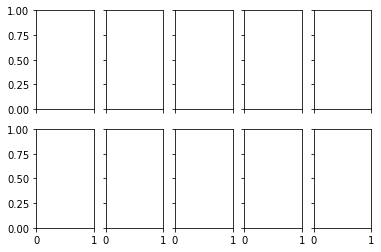

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

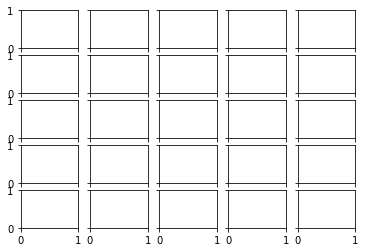

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
digit = 7
x_digits = X[y == digit]
for i in range(25):
    img = x_digits[i].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1030732, 5)
(1030732,)
(687155, 5)
(687155,)


In [6]:

nn = MultiLayerPerceptron(2, [X_train.shape[1], 10 , 3], 0.7, 500, 0.000005, "relu")
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test.T)
print(yhat)
print(y_test)
print('Test acc:',accuracy_score(y_test,yhat))

NameError: name 'X_train' is not defined

In [7]:
plt.plot(range(len(nn.cost)), nn.cost)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

NameError: name 'nn' is not defined

In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv('../pitches.csv')

In [9]:
#drop unkown prediction classes and prediction classes with no definition from data source
df.drop_duplicates(inplace=True)
df = df[df.pitch_type != 'UN']
df = df[df.pitch_type != 'FA']

features = ['break_angle', 'break_length', 'end_speed', 'start_speed', 'spin_rate']
#remove wild pitches or intentional walks as break length outliers. Code sourced from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
for feature in features:
    if feature != 'pitch_type':
        df = df[np.abs(df[feature]-df[feature].mean()) <= (12*df[feature].std())]

#drop data points where prediction class is unreliable
df = df[df.type_confidence >= 1.0]

#Drop any data with incomplete records
df.dropna(inplace=True)

In [10]:
#separate pitches based on prediction class for visualization
# What might be a reasonable value for bounding break_length ? I picked 100.0
df = df[df.break_length <= 100.0] 
fast_pitches_super_group = df[df.pitch_type.isin(['FC','FF','FS','FT','SI'])]
fast_pitches_super_group['grouping'] = 'fast_ball'
breaking_pitches_super_group = df[df.pitch_type.isin(['CU', 'KC', 'KN', 'SL', 'SC'])]
breaking_pitches_super_group['grouping'] = 'breaking_ball'
slow_pitches_super_group = df[df.pitch_type.isin(['CH','EP','FO','PO','IN'])]
slow_pitches_super_group['grouping'] = 'slow_ball'
visualization_frames = [fast_pitches_super_group, breaking_pitches_super_group, slow_pitches_super_group]
result = pd.concat(visualization_frames)


/Users/rasimon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/rasimon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/rasimon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

In [11]:
X = result[features]
y = result['grouping']
for f in features:
    col = X[f]
    col -= min(col)
    col /= (max(col) - min(col))
y[y == "breaking_ball"] = 1
y[y == "fast_ball"] = 2
y[y == "slow_ball"] = 0

y = y.values
X = X.values
print(X, y)

/Users/rasimon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/rasimon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[[0.18151354 0.05555556 0.77719298 0.79799666 0.35226407]
 [0.13767104 0.05913978 0.77719298 0.79632721 0.41114229]
 [0.12929349 0.06451613 0.79649123 0.81803005 0.40472292]
 ...
 [0.31471656 0.10215054 0.76315789 0.74290484 0.2383596 ]
 [0.3387322  0.10573477 0.75789474 0.75292154 0.29016753]
 [0.21641999 0.12544803 0.72280702 0.69949917 0.15544979]] [2 2 2 ... 0 0 0]


/Users/rasimon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4)

In [16]:
nn = MultiLayerPerceptron(2, [X_train.shape[1], 10, 3], 0.4, 30, 0.0001, "relu")
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test.T)



print("yhat",yhat)
print("ytest", y_test)

print('Test acc:',accuracy_score(y_test.astype(np.int),yhat))

(10, 6)
(3, 11)
(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)




Epoch: 10/30

(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)




Epoch: 20/30

(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)


(10, 6)
(3, 11)




Epoch: 30/30

(10, 6)
(3, 11)


(10, 6)
(3, 11)


[0.3822813116066296, 1.4662530273246013, 1.4654295738564314, 1.4636112522443037, 1.4503356087381467, 1.331980697618198, 1.3320093632439358, 1.332037966979906, 1.3320665082313239, 1.332094986394952, 1.3321234008589404, 1.3321517510026581, 1.332180036196528, 1.3322082558018495, 1.3322364091706225, 1.3322644956453662, 1.3322925145589304, 1.3323204652343046, 1.3323483469844242, 1.3323761591119672, 1.3324039009091488, 1.3324315716575112, 1.3324591706277058, 1.3324866970792724, 1.3325141502604094, 1.3325415294077434, 1.3325688337460866, 1.3325960624881912, 1.332623214834499, 1.33265028997288]
yhat [2 2 2 ... 2 2 2]
ytest [1 2 2 ... 2 1 2]
Test acc: 0.6238636115577999


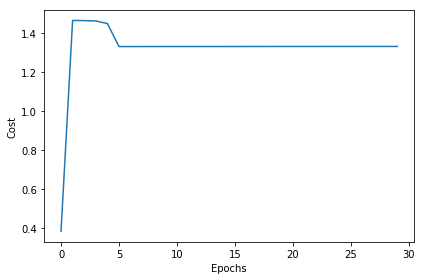

In [17]:
plt.plot(range(len(nn.cost)), nn.cost)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()